##load_lib


In [ ]:
##install lightgbm gpu version
!pip install lightgbm
!rm -r /opt/conda/lib/python3.6/site-packages/lightgbm
!git clone --recursive https://github.com/Microsoft/LightGBM
!apt-get install -y -qq libboost-all-dev

In [ ]:
%%bash
cd LightGBM
rm -r build
mkdir build
cd build
cmake -DUSE_GPU=1 -DOpenCL_LIBRARY=/usr/local/cuda/lib64/libOpenCL.so -DOpenCL_INCLUDE_DIR=/usr/local/cuda/include/ ..
make -j$(nproc)

In [ ]:
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
!rm -r LightGBM

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##load_data

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
path = "/content/drive/MyDrive/Colab_Notebooks/intel_oneapi_water/dataset.csv"
df_raw = pd.read_csv(path)
df_raw

,Index,pH,Iron,Nitrate,Chloride,Lead,Zinc,Color,Turbidity,Fluoride,...,Chlorine,Manganese,Total Dissolved Solids,Source,Water Temperature,Air Temperature,Month,Day,Time of Day,Target
0,0,8.332988,0.000083,8.605777,122.799772,3.713298e-52,3.434827,Colorless,0.022683,0.607283,...,3.708178,2.269945e-15,332.118789,NaN,NaN,43.493324,January,29.0,4.0,0
1,1,6.917863,0.000081,3.734167,227.029851,7.849262e-94,1.245317,Faint Yellow,0.019007,0.622874,...,3.292038,8.024076e-07,284.641984,Lake,15.348981,71.220586,November,26.0,16.0,0
2,2,5.443762,0.020106,3.816994,230.995630,5.286616e-76,0.528280,Light Yellow,0.319956,0.423423,...,3.560224,7.007989e-02,570.054094,River,11.643467,44.891330,January,31.0,8.0,0
3,3,7.955339,0.143988,8.224944,178.129940,3.997118e-176,4.027879,Near Colorless,0.166319,0.208454,...,3.516907,2.468295e-02,100.043838,Ground,10.092392,60.843233,April,1.0,21.0,0
4,4,8.091909,0.002167,9.925788,186.540872,4.171069e-132,3.807511,Light Yellow,0.004867,0.222912,...,3.177849,3.296139e-03,168.075545,Spring,15.249416,69.336671,June,29.0,7.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5956837,5956837,8.418457,0.000095,8.427576,256.570863,4.751543e-26,4.967504,Faint Yellow,3.824532,0.541850,...,2.630130,9.608234e-03,545.990529,Well,21.436974,70.493951,February,8.0,8.0,1
5956838,5956838,7.950573,0.215729,4.677850,292.727780,4.679421e-12,1.842063,Near Colorless,1.181166,2.747241,...,3.555576,1.875424e-11,514.136530,Ground,19.064632,67.052475,September,8.0,6.0,1
5956839,5956839,8.145572,0.000005,7.112877,254.831175,3.150254e-56,0.656923,Colorless,1.769609,1.398686,...,3.127251,1.199405e+00,336.947289,NaN,5.863636,64.086020,January,16.0,11.0,1
5956840,5956840,8.273548,0.001236,10.182408,122.842038,4.226073e-33,0.903032,Light Yellow,0.366909,3.076229,...,2.762962,2.824411e+00,112.458644,NaN,28.034083,18.158372,March,29.0,13.0,1


In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5956842 entries, 0 to 5956841
Data columns (total 24 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Index                   int64  
 1   pH                      float64
 2   Iron                    float64
 3   Nitrate                 float64
 4   Chloride                float64
 5   Lead                    float64
 6   Zinc                    float64
 7   Color                   object 
 8   Turbidity               float64
 9   Fluoride                float64
 10  Copper                  float64
 11  Odor                    float64
 12  Sulfate                 float64
 13  Conductivity            float64
 14  Chlorine                float64
 15  Manganese               float64
 16  Total Dissolved Solids  float64
 17  Source                  object 
 18  Water Temperature       float64
 19  Air Temperature         float64
 20  Month                   object 
 21  Day                     float64

In [ ]:
null_percentage = df_raw.isnull().sum() / len(df_raw) * 100
null_percentage

Index                     0.000000
pH                        1.948247
Iron                      0.667350
Nitrate                   1.774850
Chloride                  2.946712
Lead                      0.451733
Zinc                      2.620953
Color                     0.096343
Turbidity                 0.836265
Fluoride                  3.175441
Copper                    3.347445
Odor                      3.003118
Sulfate                   3.314139
Conductivity              2.750803
Chlorine                  0.970732
Manganese                 1.839616
Total Dissolved Solids    0.028035
Source                    1.481691
Water Temperature         2.824198
Air Temperature           0.499056
Month                     1.606019
Day                       1.672077
Time of Day               1.922478
Target                    0.000000
dtype: float64

In [ ]:
#Use get_dummies to create dummy variables for categorical columns
categorical_columns = df_raw.select_dtypes(include=['object']).columns
dummy_df = pd.get_dummies(df_raw, columns=categorical_columns)

In [ ]:
dummy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5956842 entries, 0 to 5956841
Data columns (total 46 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Index                   int64  
 1   pH                      float64
 2   Iron                    float64
 3   Nitrate                 float64
 4   Chloride                float64
 5   Lead                    float64
 6   Zinc                    float64
 7   Turbidity               float64
 8   Fluoride                float64
 9   Copper                  float64
 10  Odor                    float64
 11  Sulfate                 float64
 12  Conductivity            float64
 13  Chlorine                float64
 14  Manganese               float64
 15  Total Dissolved Solids  float64
 16  Water Temperature       float64
 17  Air Temperature         float64
 18  Day                     float64
 19  Time of Day             float64
 20  Target                  int64  
 21  Color_Colorless         uint8  

In [ ]:
# dropping the rows having NaN values
dummy_df.dropna(inplace=True)

# To reset the indices
dummy_df.reset_index(drop=True, inplace=True)

##feature_importance

In [ ]:
df_X = dummy_df.drop(columns=['Target'])  # Exclude the 'Target' column from features
df_Y = dummy_df['Target']

In [ ]:
df_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4111513 entries, 0 to 4111512
Data columns (total 45 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Index                   int64  
 1   pH                      float64
 2   Iron                    float64
 3   Nitrate                 float64
 4   Chloride                float64
 5   Lead                    float64
 6   Zinc                    float64
 7   Turbidity               float64
 8   Fluoride                float64
 9   Copper                  float64
 10  Odor                    float64
 11  Sulfate                 float64
 12  Conductivity            float64
 13  Chlorine                float64
 14  Manganese               float64
 15  Total Dissolved Solids  float64
 16  Water Temperature       float64
 17  Air Temperature         float64
 18  Day                     float64
 19  Time of Day             float64
 20  Color_Colorless         uint8  
 21  Color_Faint Yellow      uint8  

In [ ]:
df_Y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 4111513 entries, 0 to 4111512
Series name: Target
Non-Null Count    Dtype
--------------    -----
4111513 non-null  int64
dtypes: int64(1)
memory usage: 31.4 MB


In [ ]:
df_X.drop(columns=['Index'], inplace=True)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(df_X, df_Y, test_size=0.1)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((3700361, 44), (411152, 44), (3700361,), (411152,))

In [ ]:
clf = lgb.LGBMClassifier(class_weight='balanced',max_bin = 63,
    num_leaves = 255,
    num_iterations = 500,
    learning_rate = 0.01,
    tree_learner = 'serial',
    task = 'train',
    is_training_metric = False,
    min_data_in_leaf = 1,
    min_sum_hessian_in_leaf = 100,
    sparse_threshold=1.0,
    device = 'gpu',
    num_thread = -1,
    save_binary= True,
    seed= 42,
    feature_fraction_seed = 42,
    bagging_seed = 42,
    drop_seed = 42,
    data_random_seed = 42,
    objective = 'binary',
    boosting_type = 'goss',
    verbose = 1,
    metric = 'auc',
    is_unbalance = True,
    boost_from_average = False,)

In [ ]:
clf.fit(x_train, y_train, eval_set=[(x_val, y_val)])

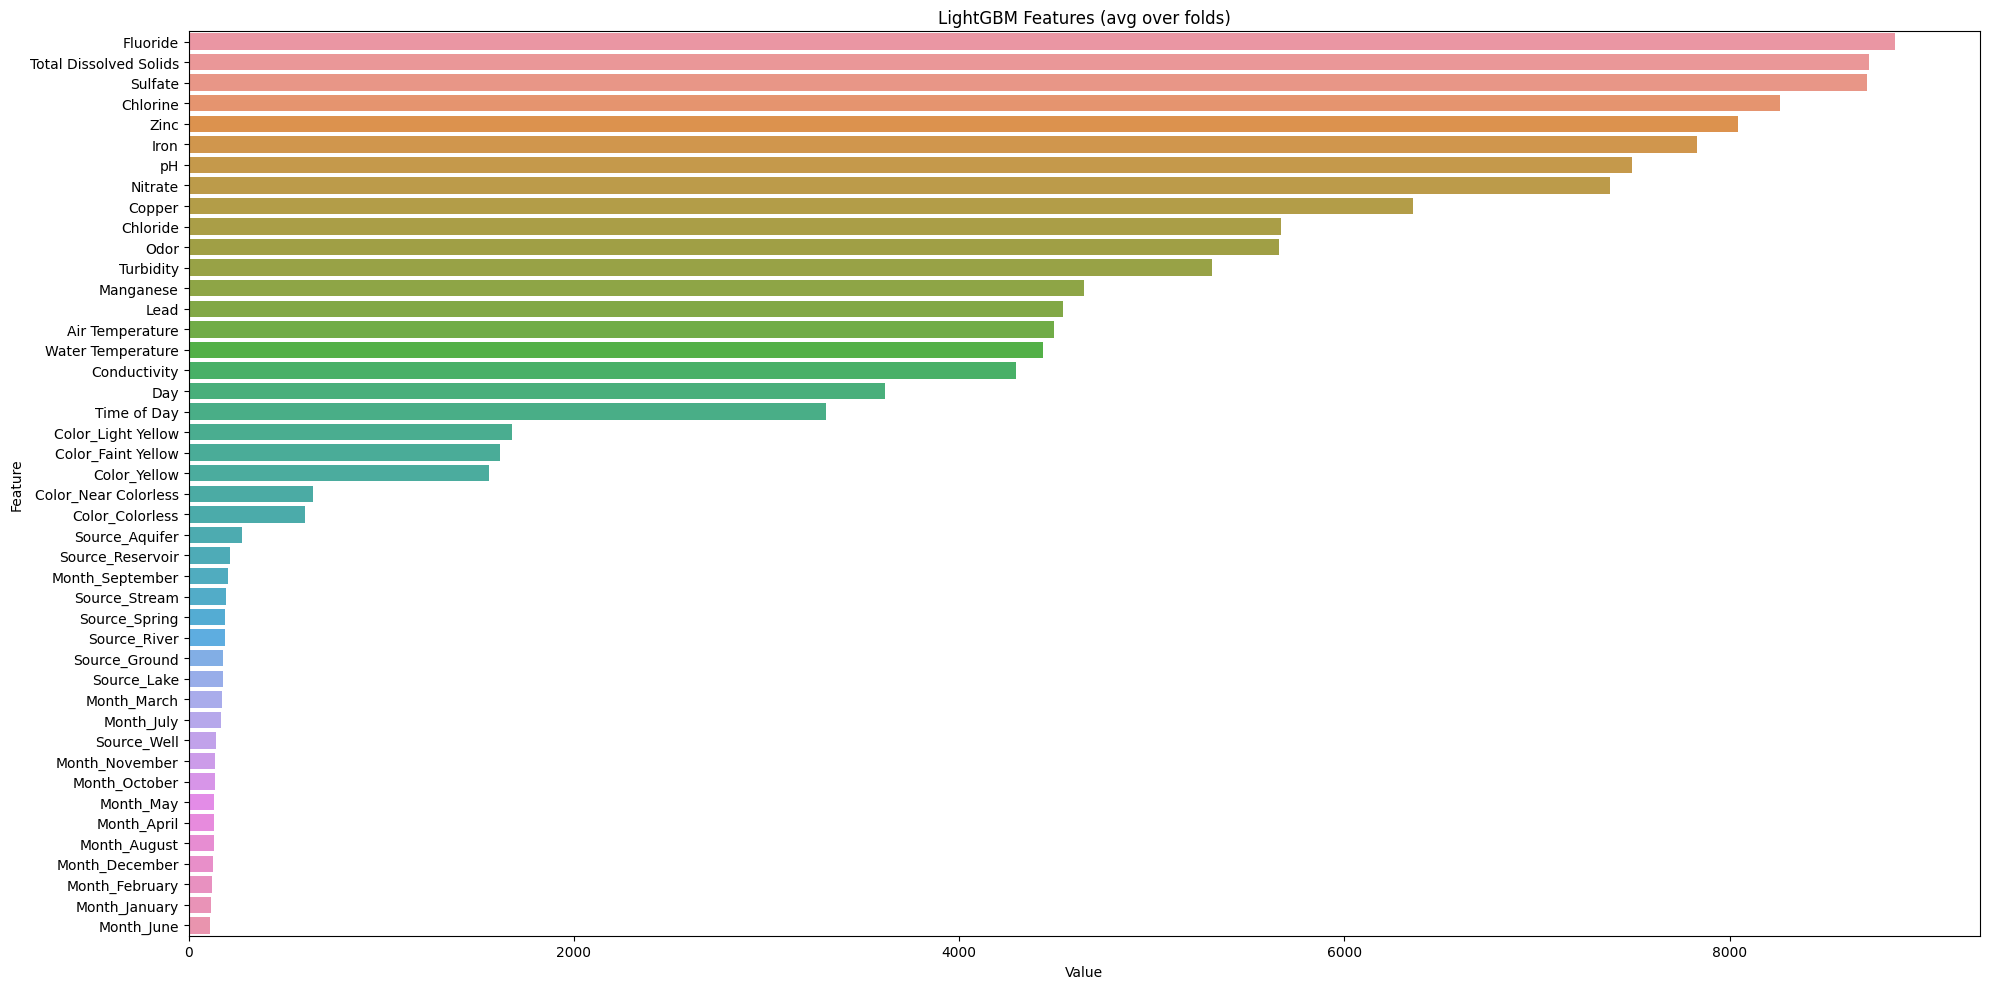

<Figure size 640x480 with 0 Axes>

In [ ]:
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,df_X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

In [ ]:
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/intel_oneapi_water/lgbm_importances.png')

<Figure size 640x480 with 0 Axes>

##Imputation

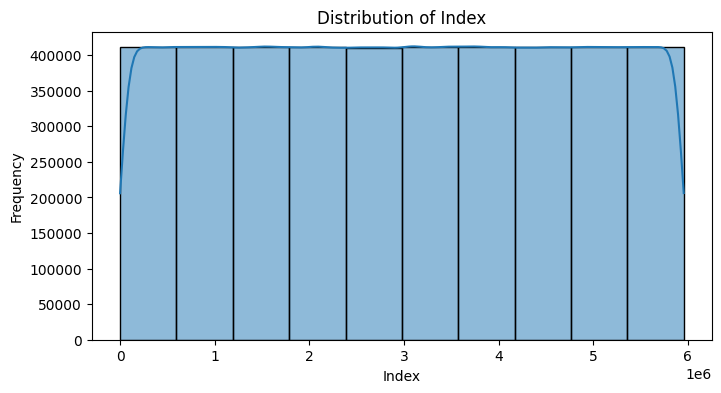

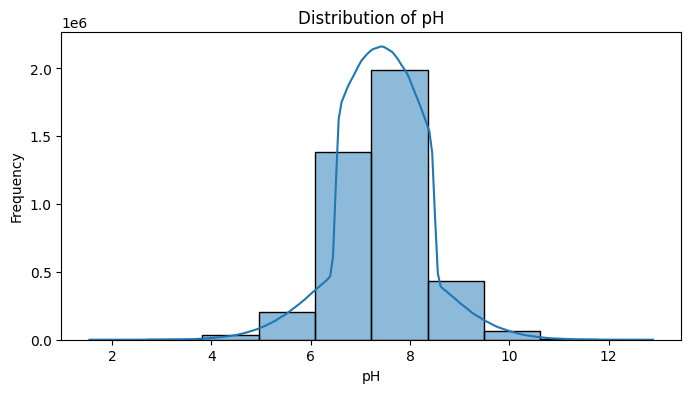

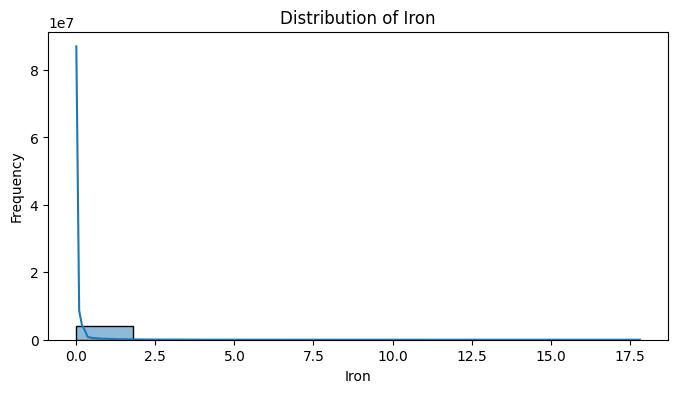

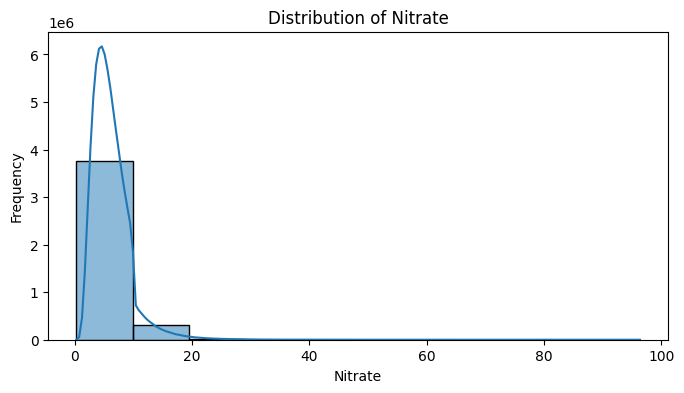

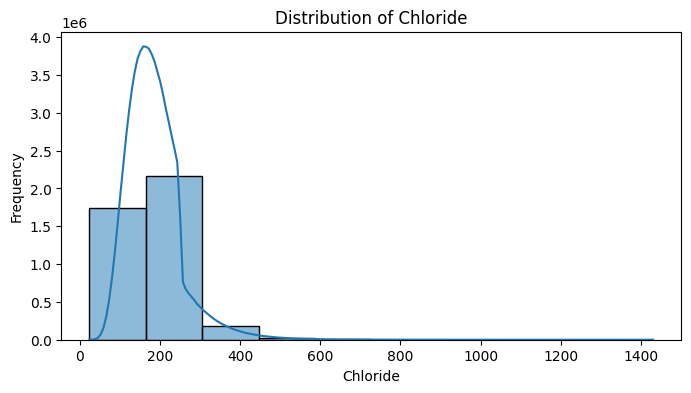

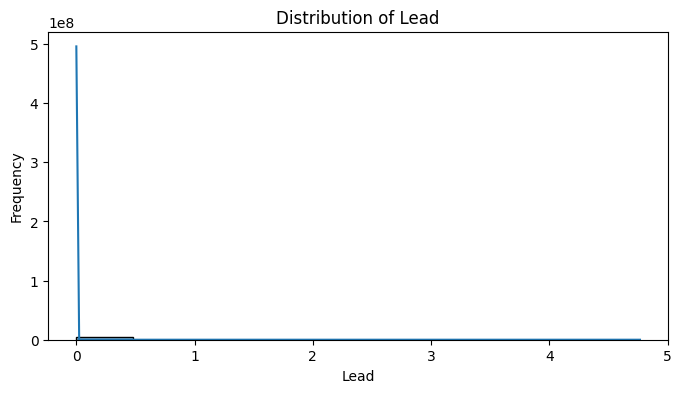

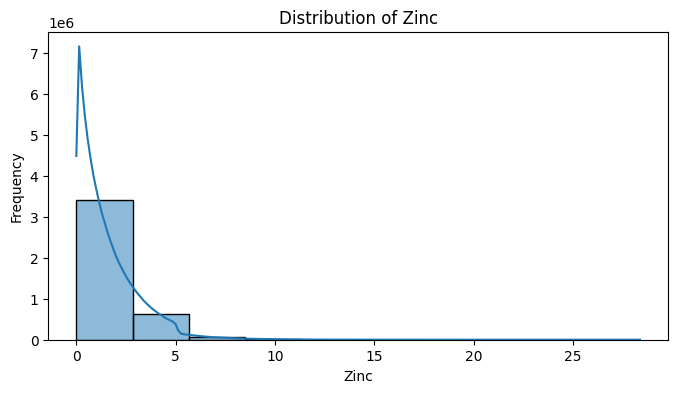

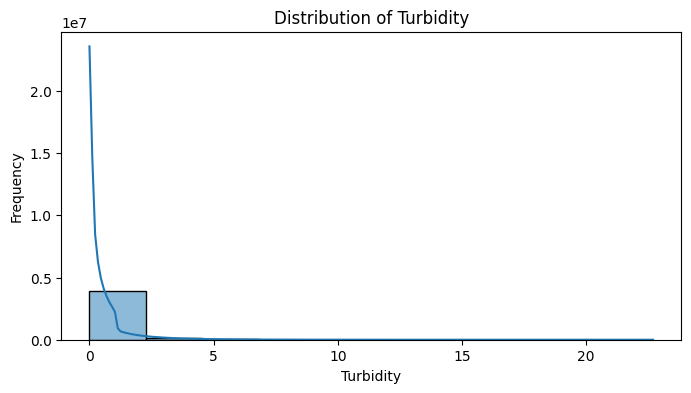

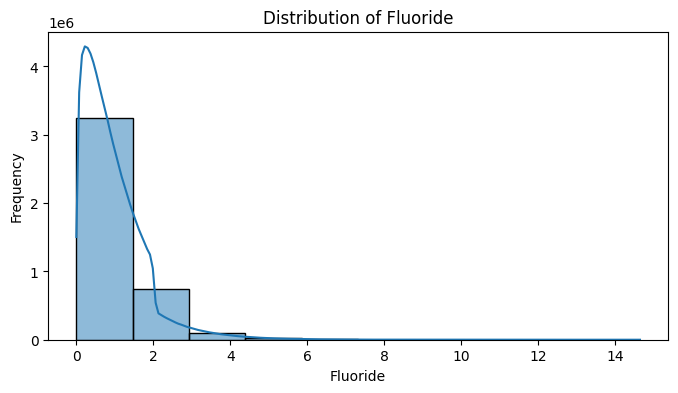

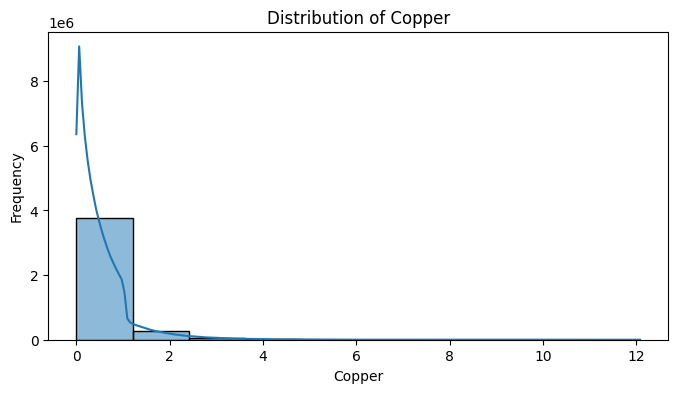

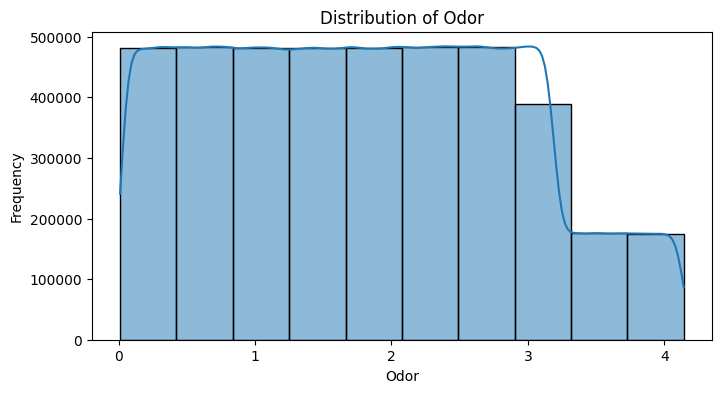

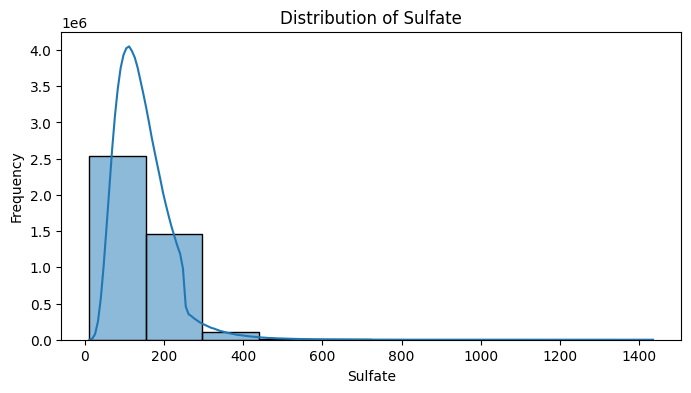

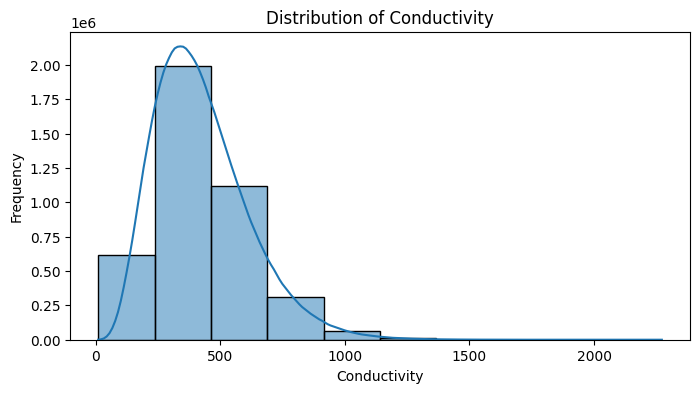

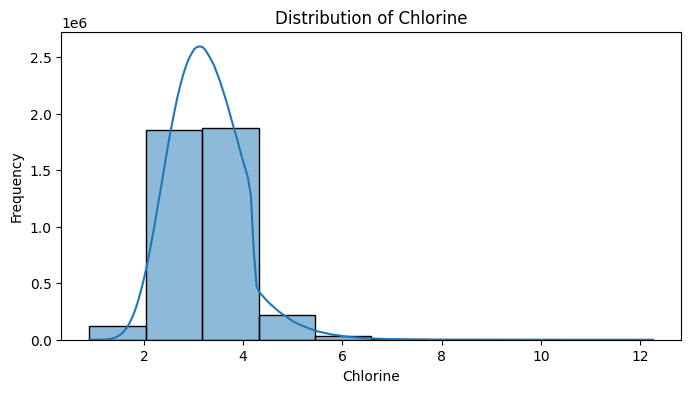

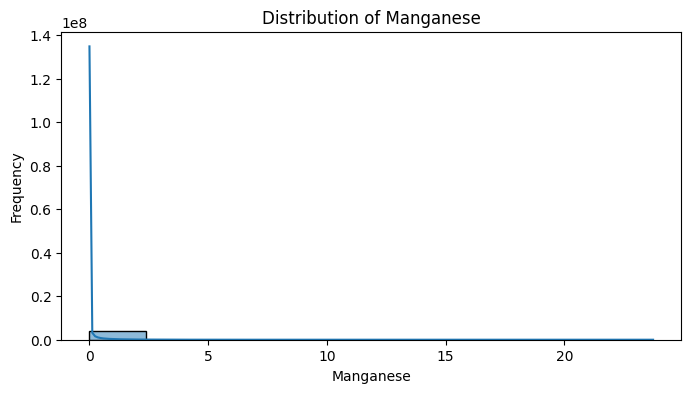

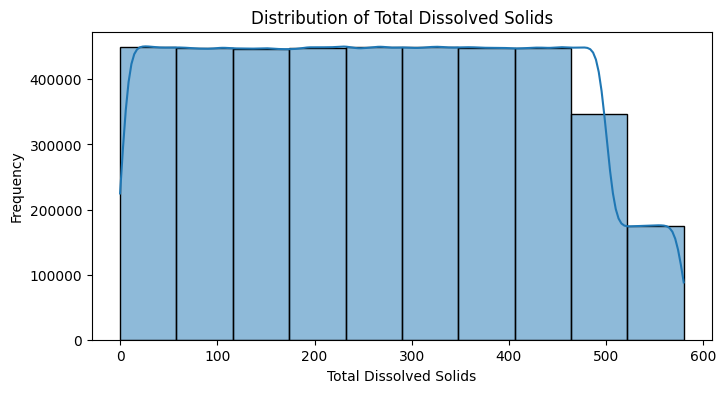

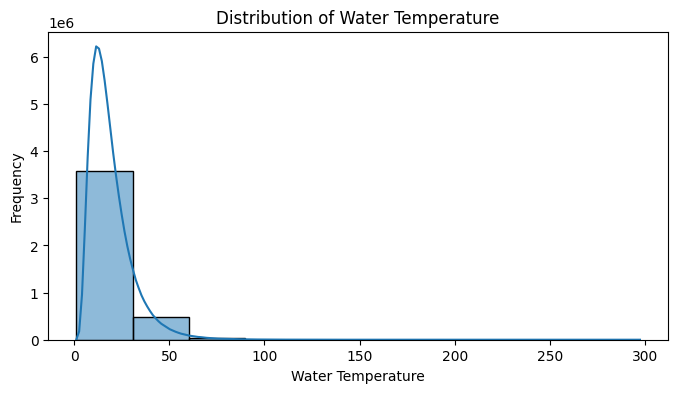

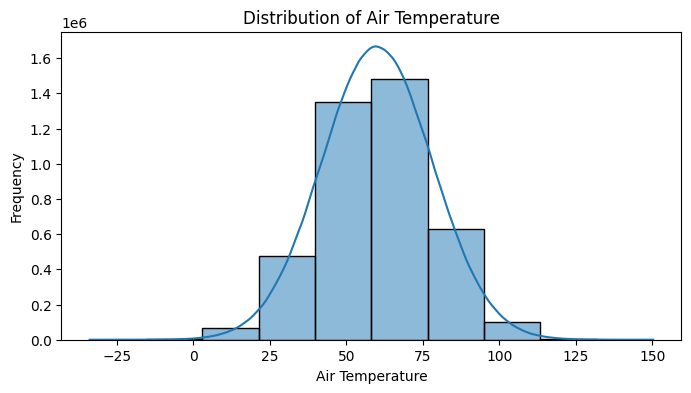

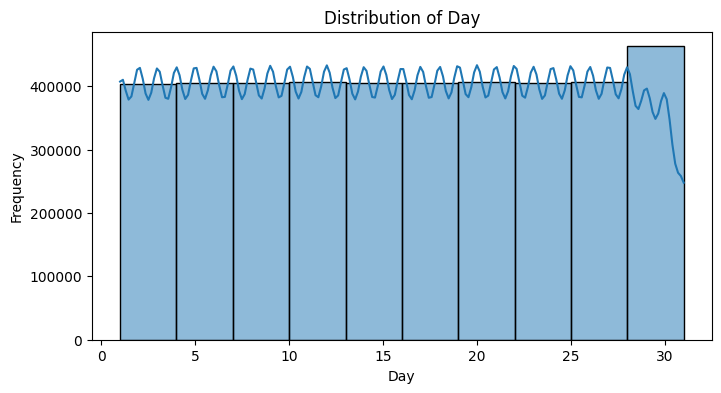

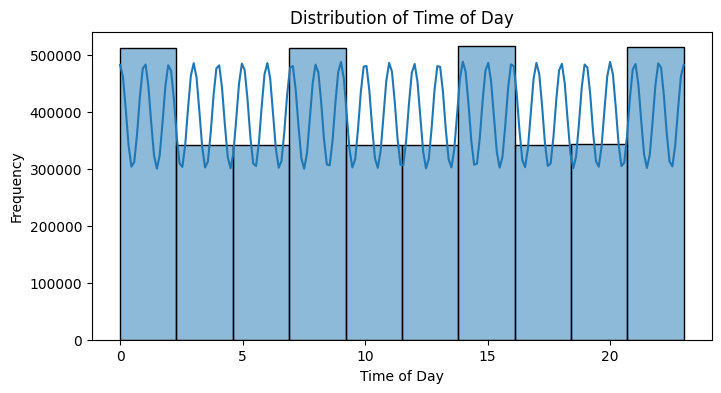

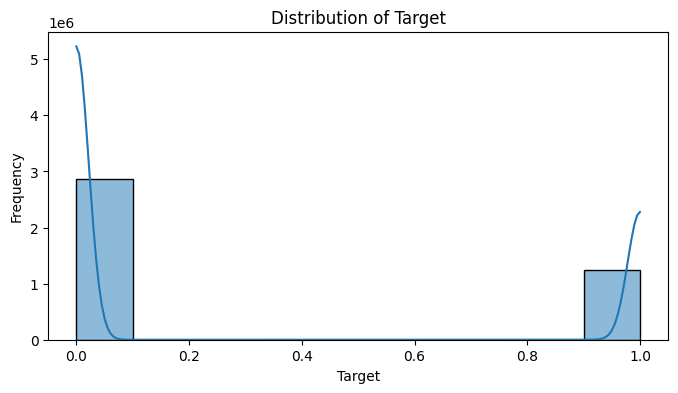

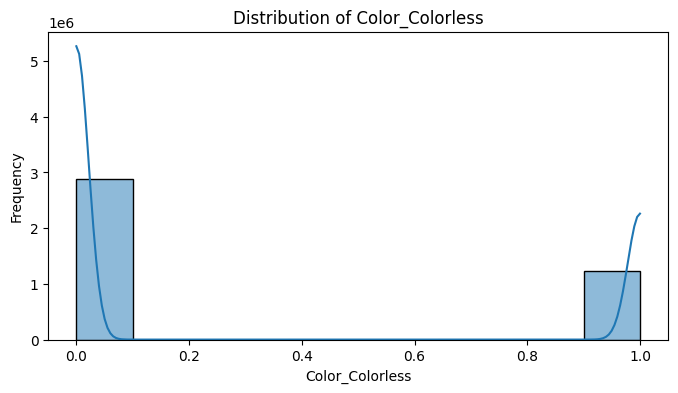

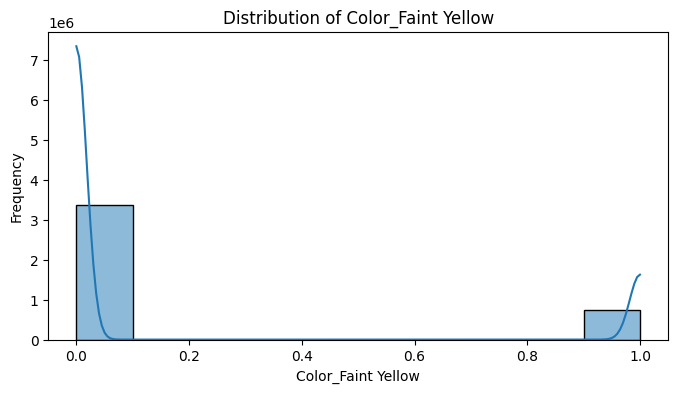

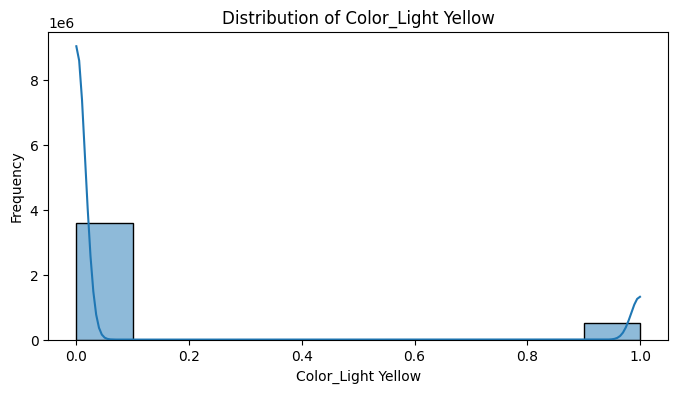

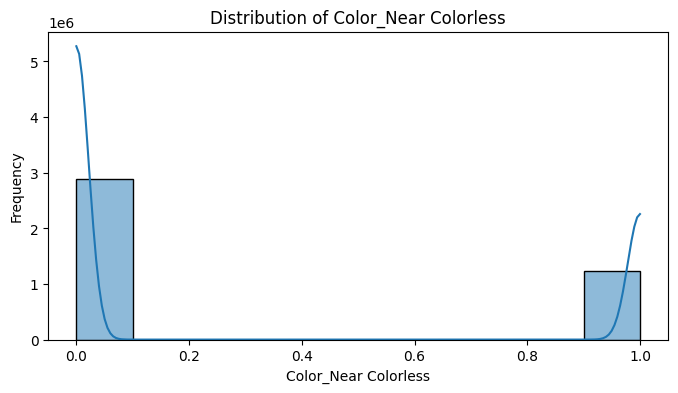

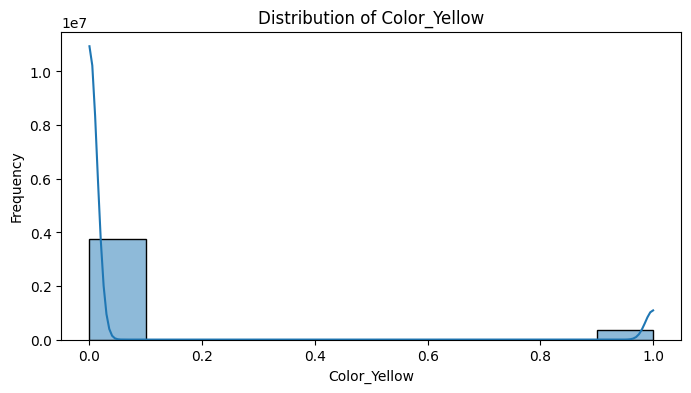

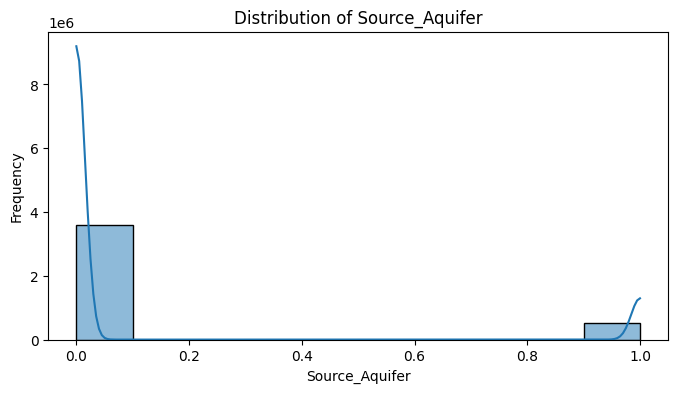

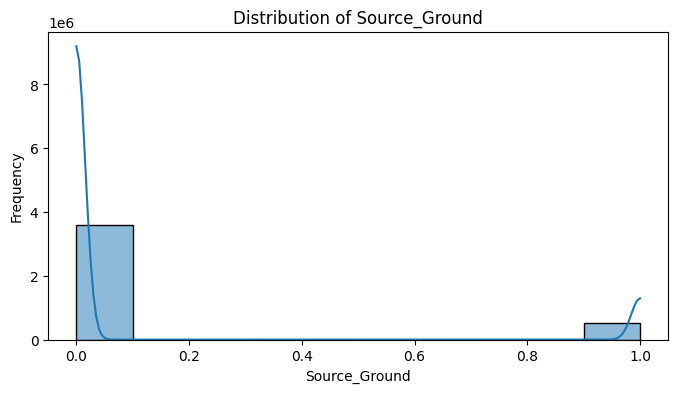

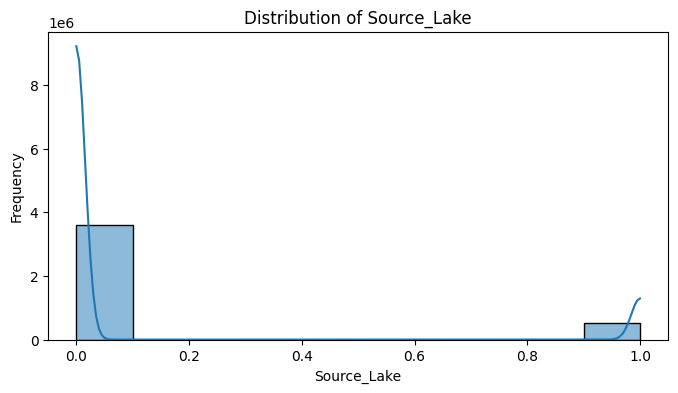

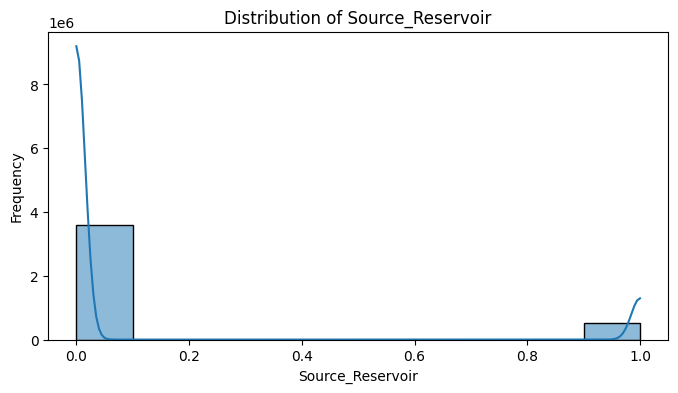

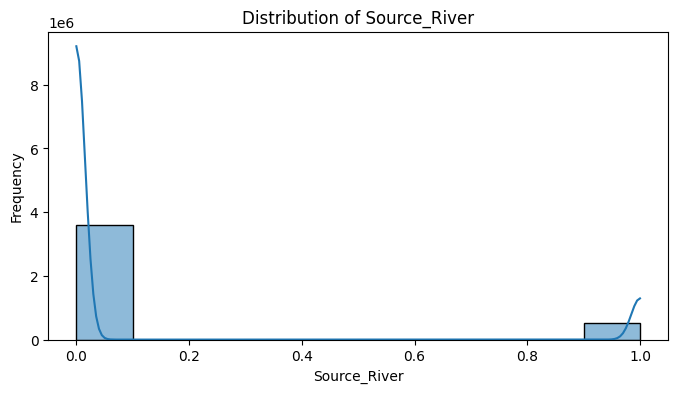

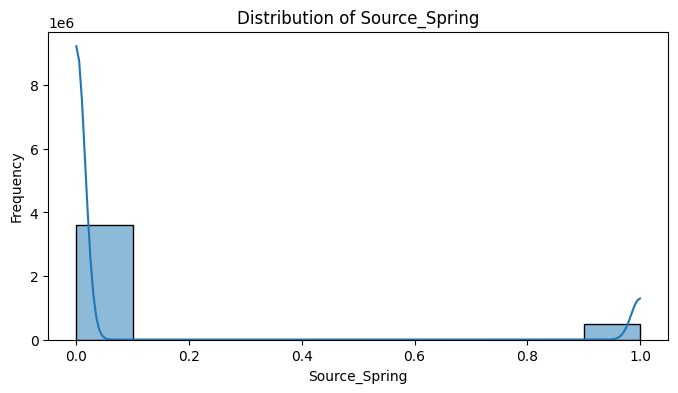

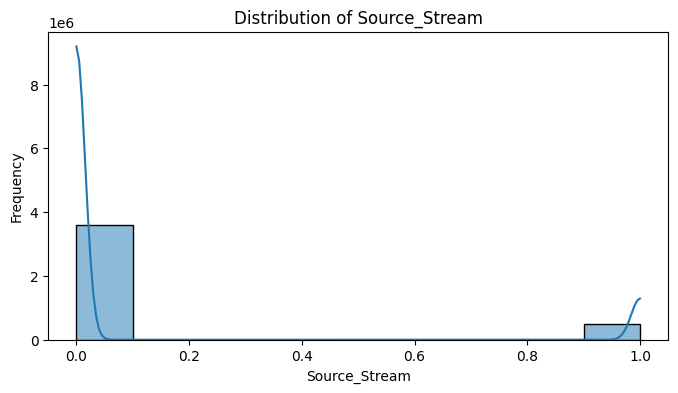

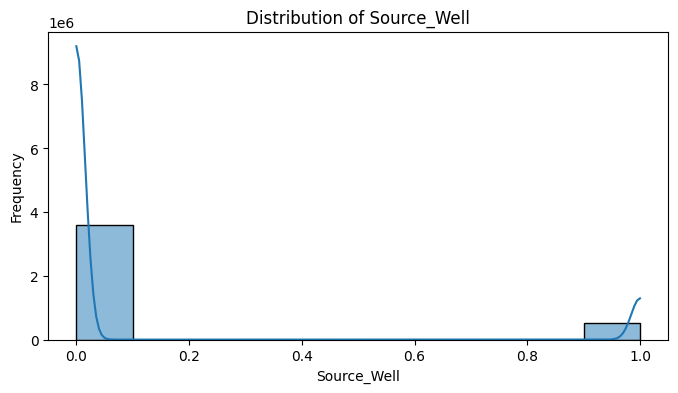

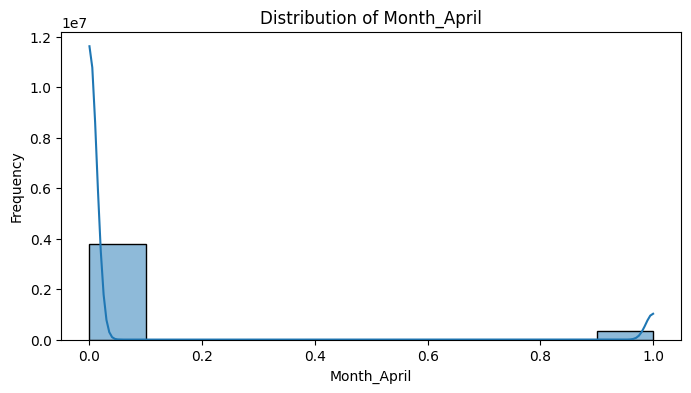

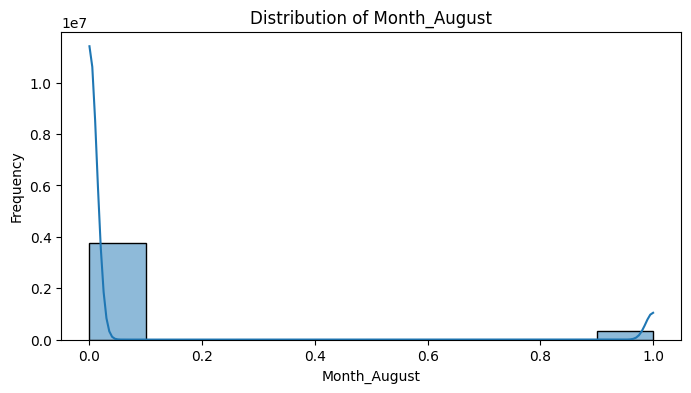

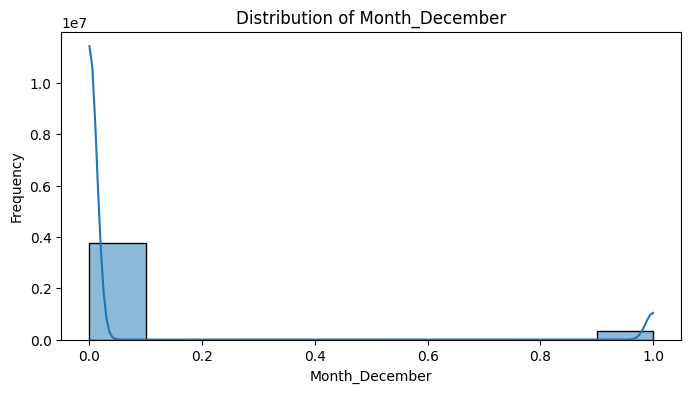

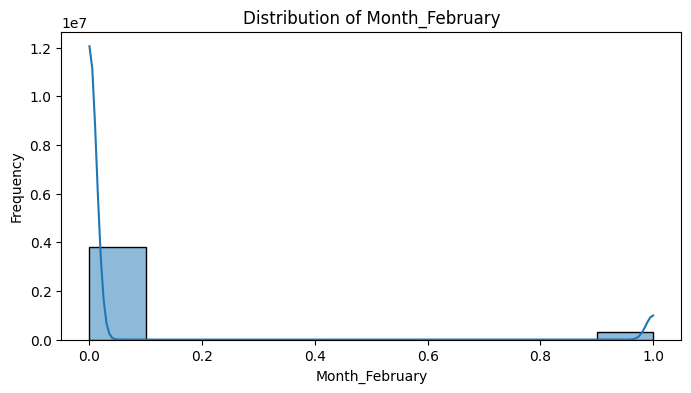

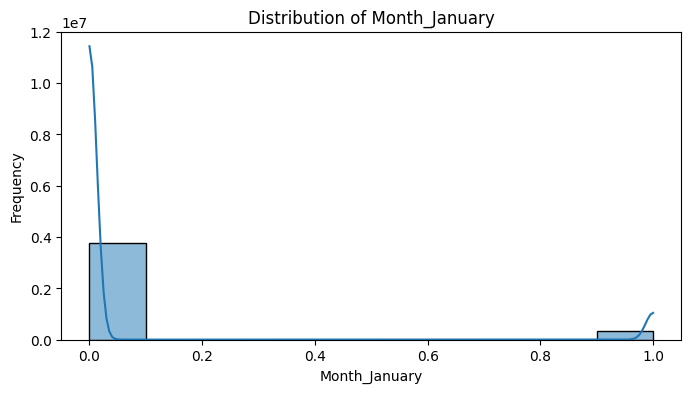

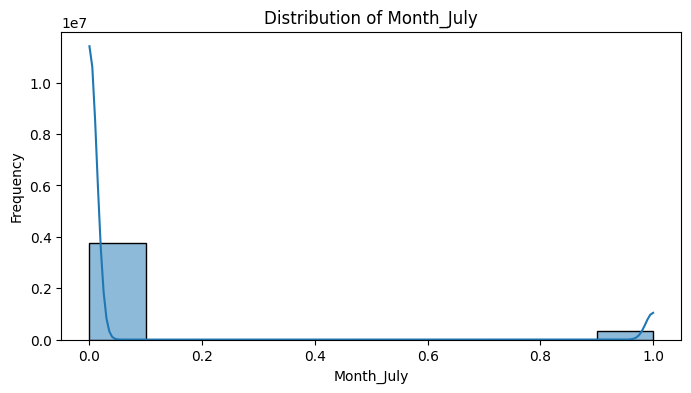

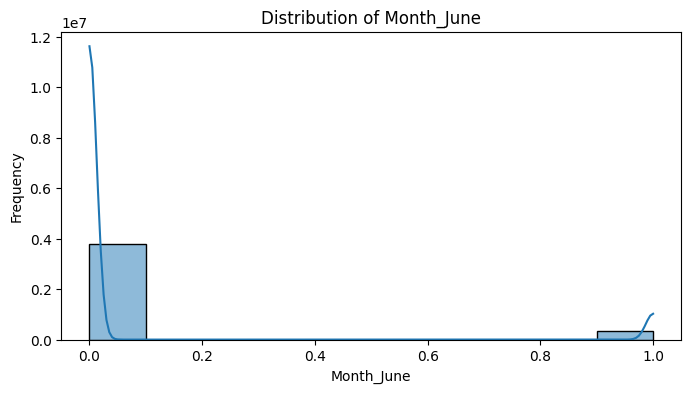

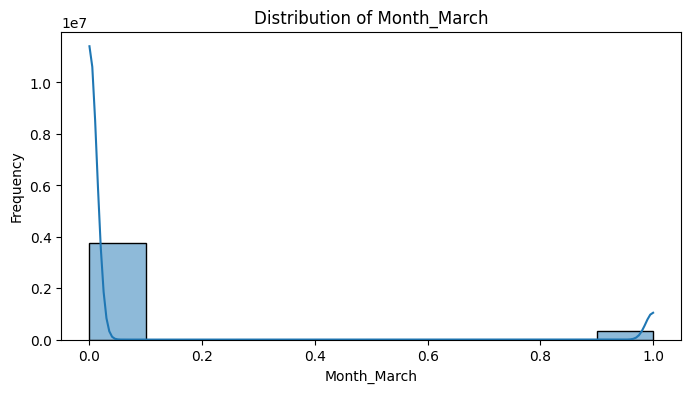

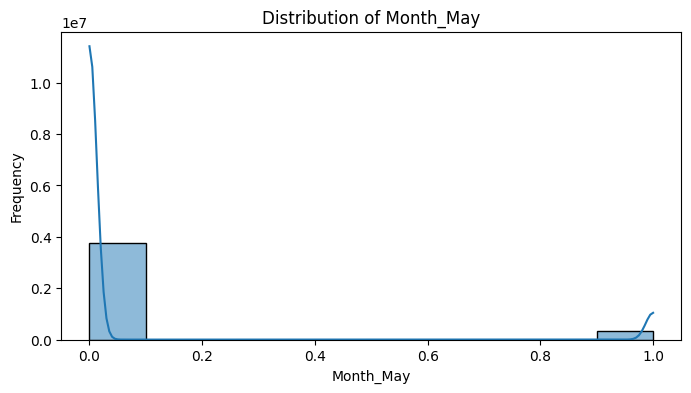

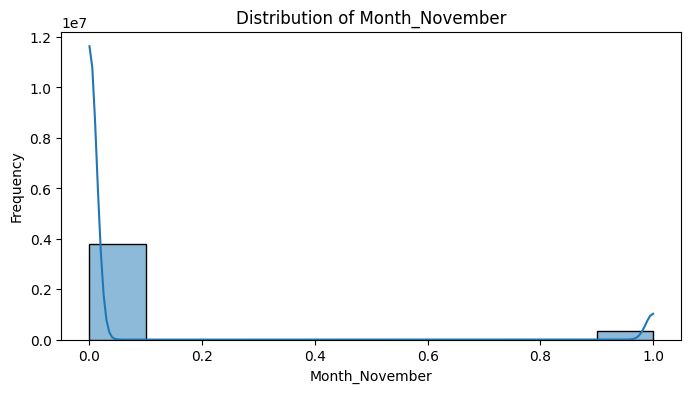

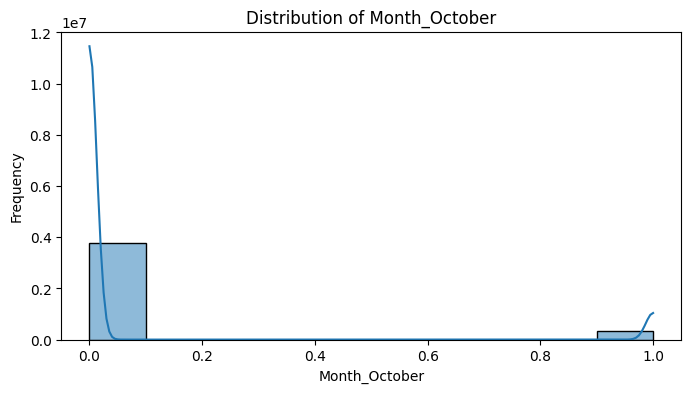

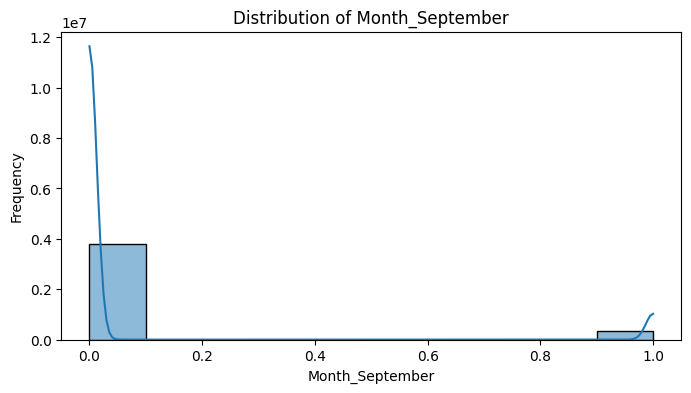

In [ ]:
# Filter columns with numeric data
numeric_columns = dummy_df.select_dtypes(include=['number'])

# Plot the distribution of numeric columns with limited bins
for column in numeric_columns.columns:
    plt.figure(figsize=(8, 4))  # Adjust the figure size if needed
    sns.histplot(data=numeric_columns, x=column, kde=True, bins=10)  # Adjust the number of bins (e.g., bins=10)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
# impute missing values with the
# mean if the variable is normally distributed, and
# the median if the distribution is skewed

In [ ]:
df_raw.columns

Index(['Index', 'pH', 'Iron', 'Nitrate', 'Chloride', 'Lead', 'Zinc', 'Color',
       'Turbidity', 'Fluoride', 'Copper', 'Odor', 'Sulfate', 'Conductivity',
       'Chlorine', 'Manganese', 'Total Dissolved Solids', 'Source',
       'Water Temperature', 'Air Temperature', 'Month', 'Day', 'Time of Day',
       'Target'],
      dtype='object')

In [ ]:
## drop features which are not important accroding to lgbm model output feature importance
## which here are 'Source'& 'Month'
df_raw.drop(columns=['Source', 'Month'], inplace=True)

In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5956842 entries, 0 to 5956841
Data columns (total 22 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Index                   int64  
 1   pH                      float64
 2   Iron                    float64
 3   Nitrate                 float64
 4   Chloride                float64
 5   Lead                    float64
 6   Zinc                    float64
 7   Color                   object 
 8   Turbidity               float64
 9   Fluoride                float64
 10  Copper                  float64
 11  Odor                    float64
 12  Sulfate                 float64
 13  Conductivity            float64
 14  Chlorine                float64
 15  Manganese               float64
 16  Total Dissolved Solids  float64
 17  Water Temperature       float64
 18  Air Temperature         float64
 19  Day                     float64
 20  Time of Day             float64
 21  Target                  int64  

In [ ]:
categorical_columns = df_raw.select_dtypes(include=['object']).columns
dummy_df = pd.get_dummies(df_raw, columns=categorical_columns)

In [ ]:
columns_to_mean_impute  = ['pH','Air Temperature']
columns_to_median_impute = ['Iron', 'Nitrate', 'Chloride', 'Lead', 'Zinc' , 'Turbidity', 'Fluoride', 'Copper', 'Total Dissolved Solids', 'Water Temperature', 'Chlorine',
                            "Conductivity", 'Sulfate', 'Odor', 'Manganese', 'Day', 'Time of Day']

In [ ]:
# Apply mean imputation to specified columns
dummy_df[columns_to_mean_impute] = dummy_df[columns_to_mean_impute].fillna(dummy_df[columns_to_mean_impute].mean())

# Apply median imputation to specified columns
dummy_df[columns_to_median_impute] = dummy_df[columns_to_median_impute].fillna(dummy_df[columns_to_median_impute].median())

In [ ]:
dummy_df.isnull().sum()

pH                        0
Iron                      0
Nitrate                   0
Chloride                  0
Lead                      0
Zinc                      0
Turbidity                 0
Fluoride                  0
Copper                    0
Odor                      0
Sulfate                   0
Conductivity              0
Chlorine                  0
Manganese                 0
Total Dissolved Solids    0
Water Temperature         0
Air Temperature           0
Day                       0
Time of Day               0
Target                    0
Color_Colorless           0
Color_Faint Yellow        0
Color_Light Yellow        0
Color_Near Colorless      0
Color_Yellow              0
dtype: int64

In [ ]:
dummy_df.drop(columns=['Index'], inplace=True)

In [ ]:
dummy_df.to_csv("/content/drive/MyDrive/Colab_Notebooks/intel_oneapi_water/final_water_cleaned_data.csv",
                  index=False)

In [ ]:
dummy_df['Target'].value_counts()

0    4151590
1    1805252
Name: Target, dtype: int64